# Proyecto hibridacion de algoritmos de deep learning

LSTM + AUTO ENCODER

## Integrantes

- Medina Barreras Daniel Ivan
- Integrante 2
- Integrante 3


# Sección 1: LSTM


In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error


In [ ]:
train_df  = pd.read_csv('/content/train.csv')
test_df  = pd.read_csv('/content/test.csv', usecols=['date', 'store', 'item'])  # Cargar test_data sin la primera columna 'id'

In [ ]:
# Convertir la columna 'date' a tipo datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])

# Agrupar las ventas por día en los datos de entrenamiento
daily_sales = train_df.groupby('date').sum()['sales'].reset_index()

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_sales['sales'].values.reshape(-1, 1))


In [ ]:
# Crear secuencias para LSTM
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

seq_length = 30
X, y = create_sequences(scaled_data, seq_length)

# Dividir los datos en entrenamiento y validación usando train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Redimensionar los datos para el LSTM
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)



## Modelo lstms

In [ ]:
# Crear el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(seq_length, 1)))
model.add(Dropout(0.2))
model.add(LSTM(50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(25))
model.add(Dense(1))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Configurar Early Stopping y Model Checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')


In [ ]:
# Entrenar el modelo
history = model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), callbacks=[early_stop, checkpoint])


Epoch 1/20
45/45 [==============================] - 10s 54ms/step - loss: 0.0269 - val_loss: 0.0136
Epoch 2/20
10/45 [=====>........................] - ETA: 0s - loss: 0.0157

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 1s 18ms/step - loss: 0.0153 - val_loss: 0.0139
Epoch 3/20
45/45 [==============================] - 1s 16ms/step - loss: 0.0154 - val_loss: 0.0132
Epoch 4/20
45/45 [==============================] - 1s 19ms/step - loss: 0.0146 - val_loss: 0.0128
Epoch 5/20
45/45 [==============================] - 1s 18ms/step - loss: 0.0142 - val_loss: 0.0133
Epoch 6/20
45/45 [==============================] - 1s 16ms/step - loss: 0.0141 - val_loss: 0.0132
Epoch 7/20
45/45 [==============================] - 1s 17ms/step - loss: 0.0141 - val_loss: 0.0134
Epoch 8/20
45/45 [==============================] - 1s 18ms/step - loss: 0.0140 - val_loss: 0.0138
Epoch 9/20
45/45 [==============================] - 1s 22ms/step - loss: 0.0140 - val_loss: 0.0127
Epoch 10/20
45/45 [==============================] - 1s 16ms/step - loss: 0.0146 - val_loss: 0.0135
Epoch 11/20
45/45 [==============================] - 1s 23ms/step - loss: 0.0141 - val_loss: 0.0127
Epoch 12/20
45/45 [

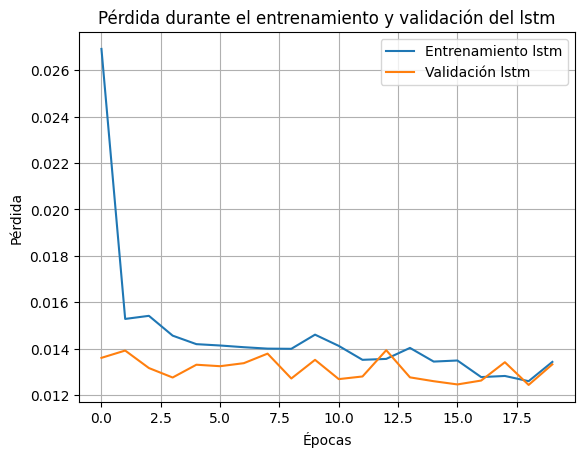

In [ ]:
# Graficar la pérdida durante el entrenamiento y validación del lstm
plt.plot(history.history['loss'], label='Entrenamiento lstm')
plt.plot(history.history['val_loss'], label='Validación lstm')
plt.title('Pérdida durante el entrenamiento y validación del lstm')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Evaluar el modelo
val_loss = model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss}")


12/12 [==============================] - 0s 4ms/step - loss: 0.0133
Validation Loss: 0.013321084901690483


In [ ]:
best_model = load_model('/content/best_model.h5')


## Pruebas para el LSTM

12/12 [==============================] - 1s 3ms/step


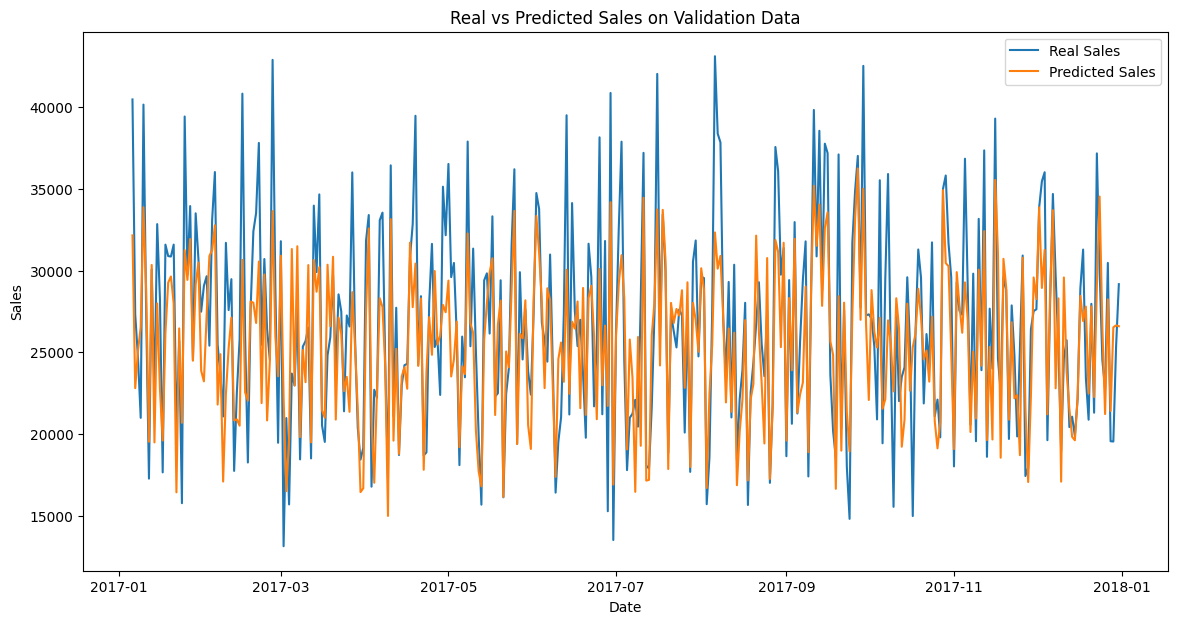

In [ ]:
# Realizar predicciones en el conjunto de validación
predictions = model.predict(X_val)

# Invertir la escala de las predicciones y los valores reales
predicted_sales = scaler.inverse_transform(predictions)
real_sales = scaler.inverse_transform(y_val.reshape(-1, 1))

# Crear un DataFrame con las predicciones y los valores reales
validation_dates = daily_sales['date'][-len(y_val):].reset_index(drop=True)
validation_df = pd.DataFrame({'date': validation_dates, 'real_sales': real_sales.flatten(), 'predicted_sales': predicted_sales.flatten()})

# Plotear las ventas reales vs las ventas predichas
plt.figure(figsize=(14, 7))
plt.plot(validation_df['date'], validation_df['real_sales'], label='Real Sales')
plt.plot(validation_df['date'], validation_df['predicted_sales'], label='Predicted Sales')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Real vs Predicted Sales on Validation Data')
plt.legend()
plt.show()

In [ ]:
# Realizar predicciones en el conjunto de validación
predictions_val = model.predict(X_val)

# Invertir la escala de las predicciones y los valores reales del conjunto de validación
predicted_sales_val = scaler.inverse_transform(predictions_val)
real_sales_val = scaler.inverse_transform(y_val.reshape(-1, 1))

# Calcular el error medio absoluto en el conjunto de validación
mae_val = mean_absolute_error(real_sales_val, predicted_sales_val)
print(f"Mean Absolute Error (Validation): {mae_val}")

12/12 [==============================] - 0s 3ms/step
Mean Absolute Error (Validation): 2987.3012179904513


## Probar el modelo para daos nuevos

In [ ]:
test_df['date']

0       2018-01-01
1       2018-01-02
2       2018-01-03
3       2018-01-04
4       2018-01-05
           ...    
44995   2018-03-27
44996   2018-03-28
44997   2018-03-29
44998   2018-03-30
44999   2018-03-31
Name: date, Length: 45000, dtype: datetime64[ns]

In [ ]:
last_sequence = scaled_data[-seq_length:]
predictions = []

for _ in range(len(test_df['date'].unique())):
    last_sequence = last_sequence.reshape((1, seq_length, 1))
    next_prediction = model.predict(last_sequence)
    predictions.append(next_prediction[0, 0])
    # Asegurarse de que next_prediction tenga la misma cantidad de dimensiones
    last_sequence = np.append(last_sequence[:, 1:, :], [[next_prediction[0]]], axis=1)

1/1 [==============================] - 0s 38ms/step


Ultimos 30 dias

In [ ]:
last_sequence

array([[[0.21644942],
        [0.21555842],
        [0.21465056],
        [0.21373419],
        [0.21282049],
        [0.21192108],
        [0.21104302],
        [0.21018921],
        [0.20935912],
        [0.20855016],
        [0.20775911],
        [0.20698321],
        [0.20622206],
        [0.20547508],
        [0.20474191],
        [0.20402236],
        [0.20331629],
        [0.20262362],
        [0.20194434],
        [0.20127983],
        [0.20063026],
        [0.19999529],
        [0.19937409],
        [0.19876567],
        [0.19816922],
        [0.19758414],
        [0.19701141],
        [0.19645105],
        [0.19590284],
        [0.1953662 ]]])

In [ ]:
# Invertir la escala de las predicciones
predicted_sales = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Crear un DataFrame con las predicciones
prediction_dates = test_df['date'].unique()
predictions_df = pd.DataFrame({'date': prediction_dates, 'predicted_sales': predicted_sales.flatten()})

# Mostrar las predicciones
print(predictions_df)

         date  predicted_sales
0  2018-01-01     21503.732422
1  2018-01-02     21591.236328
2  2018-01-03     21738.482422
3  2018-01-04     22077.873047
4  2018-01-05     22305.285156
..        ...              ...
85 2018-03-27     18274.126953
86 2018-03-28     18255.099609
87 2018-03-29     18236.478516
88 2018-03-30     18218.263672
89 2018-03-31     18200.433594

[90 rows x 2 columns]


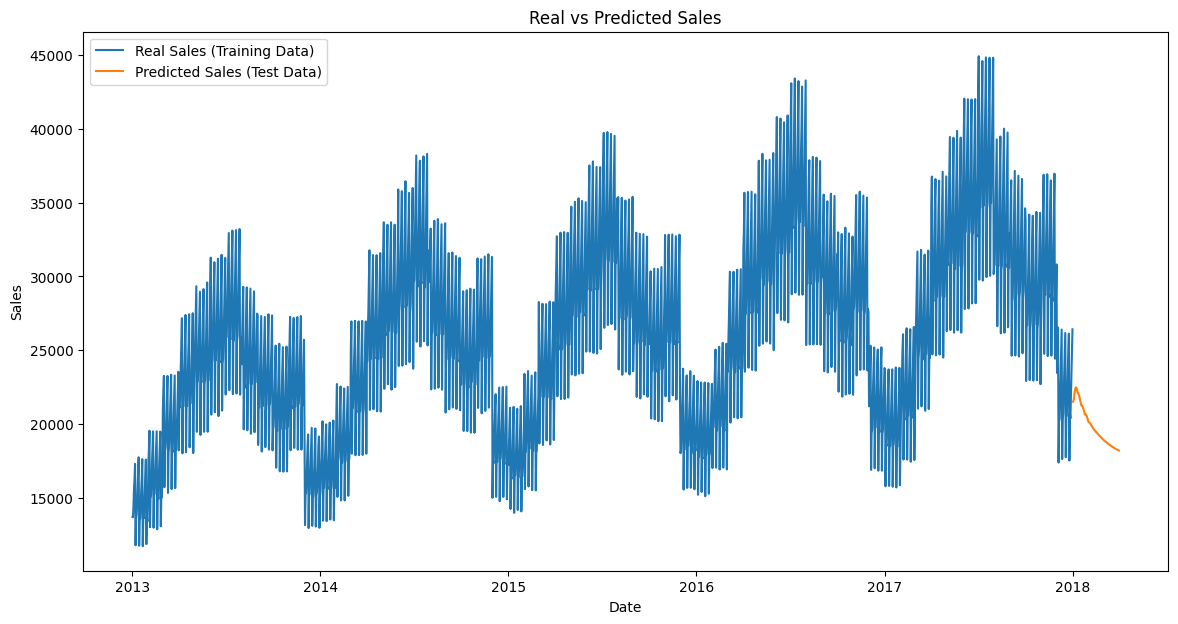

In [ ]:
# Combinar datos de entrenamiento, validación y predicciones
combined_df = pd.concat([daily_sales, predictions_df], ignore_index=True)

# Plotear las ventas reales y las ventas predichas
plt.figure(figsize=(14, 7))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Real Sales (Training Data)')
plt.plot(predictions_df['date'], predictions_df['predicted_sales'], label='Predicted Sales (Test Data)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Real vs Predicted Sales')
plt.legend()
plt.show()

## Sección 2: Autoencoder


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt

In [2]:
# Cargar los datos
train_df = pd.read_csv('/content/train.csv')

# Convertir la columna 'date' a tipo datetime
train_df['date'] = pd.to_datetime(train_df['date'])

# Agrupar las ventas por día
daily_sales = train_df.groupby('date').sum()['sales'].reset_index()

# Escalar los datos
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_sales['sales'].values.reshape(-1, 1))

# Crear secuencias para el autoencoder
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

seq_length = 30
X = create_sequences(scaled_data, seq_length)

# Dividir los datos en entrenamiento y validación usando train_test_split
X_train, X_val = train_test_split(X, test_size=0.2, random_state=42)

# Redimensionar los datos para el autoencoder
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1])

In [3]:
# Definir la arquitectura del autoencoder usando Sequential
model = Sequential()
model.add(Dense(128, activation="relu", input_shape=(seq_length,)))
model.add(Dropout(0.2))
model.add(Dense(64, activation="relu"))
model.add(Dense(32, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(seq_length, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer='adam', loss='mean_squared_error')

# Configurar Early Stopping y Model Checkpoint
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_autoencoder.h5', monitor='val_loss', save_best_only=True, mode='min')

In [4]:
# Entrenar el autoencoder
history = model.fit(X_train, X_train, epochs=100, batch_size=32, validation_data=(X_val, X_val), shuffle=True, callbacks=[early_stop, checkpoint])


Epoch 1/100
45/45 [==============================] - 2s 13ms/step - loss: 0.0349 - val_loss: 0.0232
Epoch 2/100
43/45 [===========================>..] - ETA: 0s - loss: 0.0152

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


45/45 [==============================] - 0s 7ms/step - loss: 0.0150 - val_loss: 0.0077
Epoch 3/100
45/45 [==============================] - 0s 5ms/step - loss: 0.0088 - val_loss: 0.0062
Epoch 4/100
45/45 [==============================] - 0s 6ms/step - loss: 0.0073 - val_loss: 0.0055
Epoch 5/100
45/45 [==============================] - 0s 6ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 6/100
45/45 [==============================] - 0s 6ms/step - loss: 0.0053 - val_loss: 0.0041
Epoch 7/100
45/45 [==============================] - 0s 6ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 8/100
45/45 [==============================] - 0s 7ms/step - loss: 0.0037 - val_loss: 0.0023
Epoch 9/100
45/45 [==============================] - 0s 6ms/step - loss: 0.0032 - val_loss: 0.0024
Epoch 10/100
45/45 [==============================] - 0s 9ms/step - loss: 0.0029 - val_loss: 0.0018
Epoch 11/100
45/45 [==============================] - 0s 6ms/step - loss: 0.0026 - val_loss: 0.0031
Epoch 12/100
45/45 [

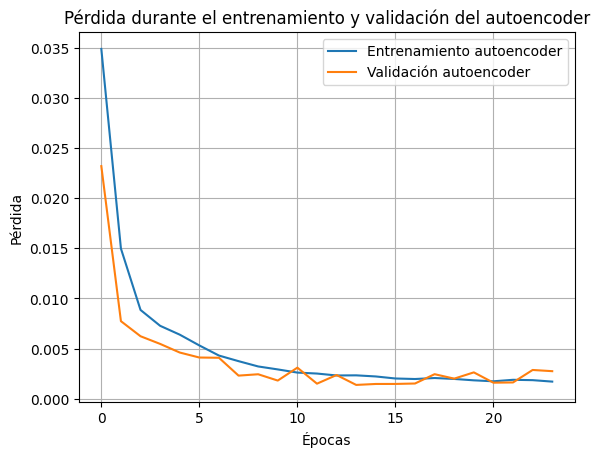

In [5]:
# Graficar la pérdida durante el entrenamiento y validación del lstm
plt.plot(history.history['loss'], label='Entrenamiento autoencoder')
plt.plot(history.history['val_loss'], label='Validación autoencoder')
plt.title('Pérdida durante el entrenamiento y validación del autoencoder')
plt.xlabel('Épocas')
plt.ylabel('Pérdida')
plt.legend()
plt.grid(True)
plt.show()

In [6]:
# Evaluar el modelo
val_loss = model.evaluate(X_val, X_val)
print(f"Validation Loss: {val_loss}")

12/12 [==============================] - 0s 2ms/step - loss: 0.0014
Validation Loss: 0.0013768289936706424


In [7]:
# Cargar el mejor modelo guardado
best_model = load_model('best_autoencoder.h5')

# Calcular el error de reconstrucción
X_train_pred = best_model.predict(X_train)
X_val_pred = best_model.predict(X_val)

# Error de reconstrucción
train_reconstruction_error = np.mean(np.abs(X_train - X_train_pred), axis=1)
val_reconstruction_error = np.mean(np.abs(X_val - X_val_pred), axis=1)


12/12 [==============================] - 0s 2ms/step


In [8]:
# Establecer un umbral para la detección de anomalías
threshold = np.percentile(train_reconstruction_error, 95)

# Identificar las anomalías en el conjunto de validación
anomalies = val_reconstruction_error > threshold

# Mostrar las fechas de las anomalías
validation_dates = daily_sales['date'][seq_length:][len(X_train):len(X_train) + len(X_val)]
anomalous_dates = validation_dates[anomalies]

# Mostrar las ventas en los días anómalos
anomalous_sales = daily_sales[daily_sales['date'].isin(anomalous_dates)]

# Crear un DataFrame con los valores finales
final_anomalies_df = pd.DataFrame({
    'date': anomalous_sales['date'],
    'sales': anomalous_sales['sales'],
    'reconstruction_error': val_reconstruction_error[anomalies]
})

# Mostrar los valores finales
print(final_anomalies_df)


           date  sales  reconstruction_error
1472 2017-01-12   1768              0.056596
1477 2017-01-17   1654              0.062301
1503 2017-02-12   2424              0.061738
1515 2017-02-24   2085              0.062893
1532 2017-03-13   1910              0.052543
1535 2017-03-16   2320              0.054613
1555 2017-04-05   2597              0.059602
1559 2017-04-09   3315              0.052325
1560 2017-04-10   2188              0.055498
1572 2017-04-22   3193              0.055109
1587 2017-05-07   3573              0.068600
1588 2017-05-08   2342              0.053775
1596 2017-05-16   2758              0.053125
1631 2017-06-20   2952              0.056903
1664 2017-07-23   4030              0.054851
1691 2017-08-19   3444              0.061739
1722 2017-09-19   2593              0.053121
1739 2017-10-06   2686              0.060884
1743 2017-10-10   2389              0.064382
1780 2017-11-16   2771              0.056130
1787 2017-11-23   2797              0.069838
1818 2017-

In [9]:
# Establecer un umbral para la detección de anomalías
threshold = np.percentile(train_reconstruction_error, 95)

# Identificar las anomalías en el conjunto de validación
anomalies = val_reconstruction_error > threshold

# Mostrar las fechas de las anomalías
validation_dates = daily_sales['date'][seq_length:][len(X_train):len(X_train) + len(X_val)]
anomalous_dates = validation_dates[anomalies]

In [10]:
# Mostrar un resumen de las anomalías
print(f"Total de días con anomalías detectadas: {anomalous_dates.count()}")
print(f"Fechas con anomalías detectadas:\n{anomalous_dates}")


Total de días con anomalías detectadas: 22
Fechas con anomalías detectadas:
1472   2017-01-12
1477   2017-01-17
1503   2017-02-12
1515   2017-02-24
1532   2017-03-13
1535   2017-03-16
1555   2017-04-05
1559   2017-04-09
1560   2017-04-10
1572   2017-04-22
1587   2017-05-07
1588   2017-05-08
1596   2017-05-16
1631   2017-06-20
1664   2017-07-23
1691   2017-08-19
1722   2017-09-19
1739   2017-10-06
1743   2017-10-10
1780   2017-11-16
1787   2017-11-23
1818   2017-12-24
Name: date, dtype: datetime64[ns]


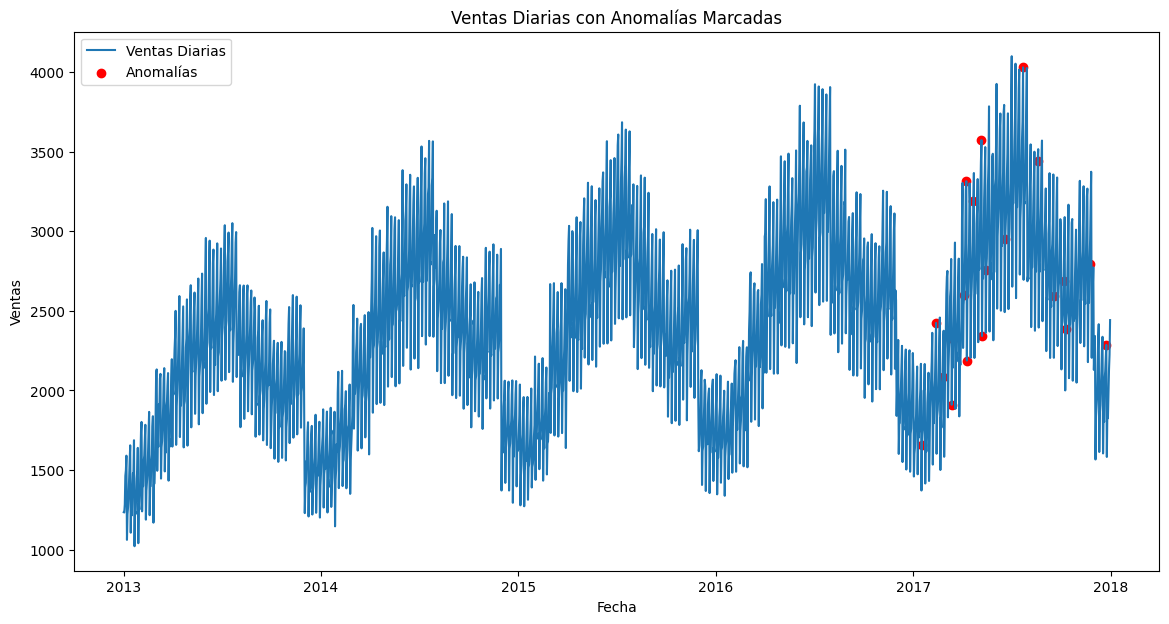

In [11]:

# Visualizar las ventas en los días anómalos
anomalous_sales = daily_sales[daily_sales['date'].isin(anomalous_dates)]

plt.figure(figsize=(14, 7))
plt.plot(daily_sales['date'], daily_sales['sales'], label='Ventas Diarias')
plt.scatter(anomalous_sales['date'], anomalous_sales['sales'], color='r', label='Anomalías')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Diarias con Anomalías Marcadas')
plt.legend()
plt.show()

In [17]:
import pandas as pd

# Crear DataFrames para las ventas de 2015, 2016 y las anomalías de 2017
comparison_2016 = []
comparison_2015 = []
anomalous_2017 = []

# Obtener las ventas de los días correspondientes en 2016, 2015 y las anomalías de 2017
for anomaly_date in anomalous_dates:
    date_2016 = anomaly_date.replace(year=2016)
    date_2015 = anomaly_date.replace(year=2015)

    sales_2016 = daily_sales[daily_sales['date'] == date_2016]['sales'].values
    sales_2015 = daily_sales[daily_sales['date'] == date_2015]['sales'].values
    sales_2017 = daily_sales[daily_sales['date'] == anomaly_date]['sales'].values

    comparison_2016.append({
        'date': date_2016,
        'sales': sales_2016[0] if len(sales_2016) > 0 else None
    })

    comparison_2015.append({
        'date': date_2015,
        'sales': sales_2015[0] if len(sales_2015) > 0 else None
    })

    anomalous_2017.append({
        'date': anomaly_date,
        'sales': sales_2017[0] if len(sales_2017) > 0 else None
    })

comparison_2016_df = pd.DataFrame(comparison_2016)
comparison_2015_df = pd.DataFrame(comparison_2015)
anomalous_2017_df = pd.DataFrame(anomalous_2017)

# Crear un DataFrame que compare las ventas de 2015, 2016 y las anomalías de 2017
comparison_df = pd.DataFrame({
    'date_2017': anomalous_2017_df['date'],
    'sales_2015': comparison_2015_df['sales'],
    'sales_2016': comparison_2016_df['sales'],
    'anomalous_sales_2017': anomalous_2017_df['sales']
})

In [18]:
comparison_df

,date_2017,sales_2015,sales_2016,anomalous_sales_2017
0,2017-01-12,1272,1625,1768
1,2017-01-17,1821,1998,1654
2,2017-02-12,1770,2002,2424
3,2017-02-24,1666,1748,2085
4,2017-03-13,2361,2673,1910
5,2017-03-16,1710,2151,2320
6,2017-04-05,3034,2532,2597
7,2017-04-09,2492,3016,3315
8,2017-04-10,2740,3282,2188
9,2017-04-22,2317,2831,3193


# Hibridacion de los 2 modelos

In [ ]:
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Cargar el modelo LSTM y el autoencoder
lstm_model = load_model('/content/best_model.h5')
autoencoder_model = load_model('/content/best_autoencoder.h5')

In [ ]:
# Escalar los datos de entrenamiento
train_df = pd.read_csv('/content/train.csv')
test_df  = pd.read_csv('/content/test.csv', usecols=['date'])  # Cargar test_data sin la primera columna 'id'
# Convertir la columna 'date' a tipo datetime
train_df['date'] = pd.to_datetime(train_df['date'])
test_df['date'] = pd.to_datetime(test_df['date'])
daily_sales = train_df.groupby('date').sum()['sales'].reset_index()
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(daily_sales['sales'].values.reshape(-1, 1))

# Crear secuencias para LSTM
seq_length = 30
def create_sequences(data, seq_length):
    sequences = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
    return np.array(sequences)

X = create_sequences(scaled_data, seq_length)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Realizar predicciones con el LSTM
predictions = []
last_sequence = scaled_data[-seq_length:]

for _ in range(len(test_df['date'].unique())):
    last_sequence = last_sequence.reshape((1, seq_length, 1))
    next_prediction = lstm_model.predict(last_sequence)
    predictions.append(next_prediction[0, 0])
    last_sequence = np.append(last_sequence[:, 1:, :], [[next_prediction[0]]], axis=1)

# Invertir la escala de las predicciones
predicted_sales = scaler.inverse_transform(np.array(predictions).reshape(-1, 1))

# Crear DataFrame con las predicciones futuras
prediction_dates = test_df['date'].unique()
predictions_df = pd.DataFrame({'date': prediction_dates, 'predicted_sales': predicted_sales.flatten()})


1/1 [==============================] - 0s 33ms/step


In [ ]:

predictions_df

,date,predicted_sales
0,2018-01-01,21793.068359
1,2018-01-02,21886.062500
2,2018-01-03,22035.031250
3,2018-01-04,22396.800781
4,2018-01-05,22650.888672
...,...,...
85,2018-03-27,20256.677734
86,2018-03-28,20240.345703
87,2018-03-29,20224.269531
88,2018-03-30,20208.449219


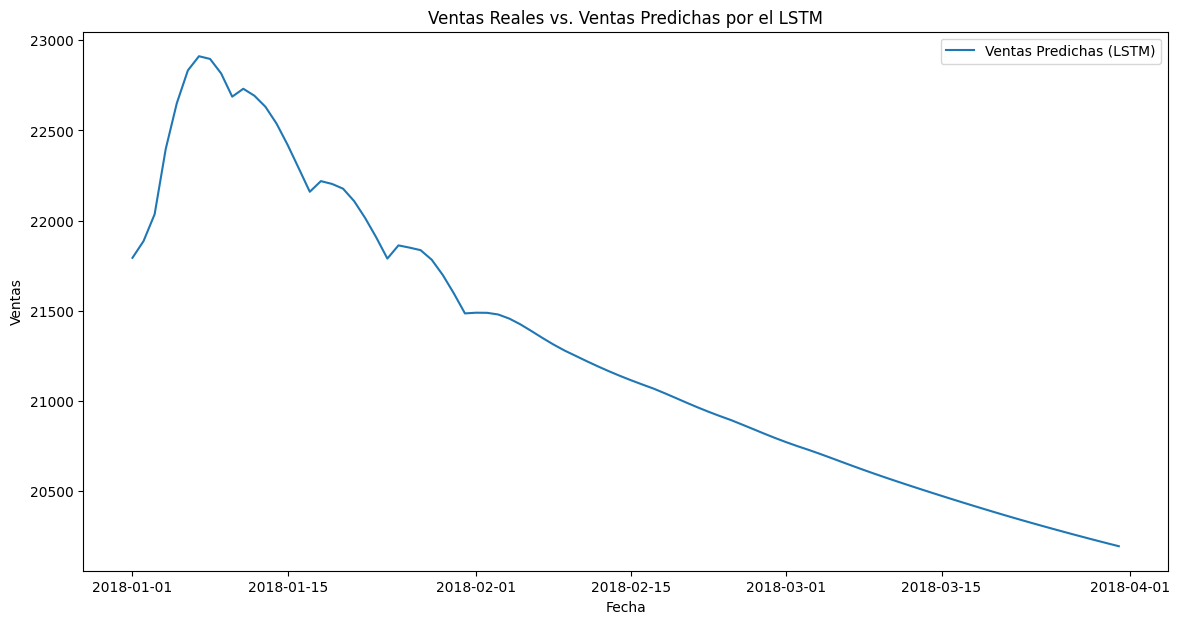

In [ ]:
# Plotear las ventas reales y las ventas predichas
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))
plt.plot(predictions_df['date'], predictions_df['predicted_sales'], label='Ventas Predichas (LSTM)')
plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Reales vs. Ventas Predichas por el LSTM')
plt.legend()
plt.show()


Paso 3: Usar el Autoencoder para Detectar Anomalías en las Predicciones del LSTM


In [ ]:
# Escalar las predicciones para el autoencoder
scaled_predictions = scaler.transform(predicted_sales)

# Crear secuencias para el autoencoder
pred_sequences = create_sequences(scaled_predictions, seq_length)

# Redimensionar las secuencias de predicciones para el autoencoder
pred_sequences = pred_sequences.reshape(pred_sequences.shape[0], pred_sequences.shape[1])

# Calcular el error de reconstrucción
pred_reconstruction = autoencoder_model.predict(pred_sequences)
pred_reconstruction = pred_reconstruction.reshape(pred_reconstruction.shape[0], pred_reconstruction.shape[1])

# Error de reconstrucción
reconstruction_error = np.mean(np.abs(pred_sequences - pred_reconstruction), axis=1)

# Establecer un umbral para la detección de anomalías
train_sequences = X.reshape(X.shape[0], X.shape[1])
train_reconstruction = autoencoder_model.predict(train_sequences)
train_reconstruction = train_reconstruction.reshape(train_reconstruction.shape[0], train_reconstruction.shape[1])

train_reconstruction_error = np.mean(np.abs(train_sequences - train_reconstruction), axis=1)

# Ajustar los umbrales utilizando la media y desviación estándar
mean_train_error = np.mean(train_reconstruction_error)
std_train_error = np.std(train_reconstruction_error)
threshold_upper = mean_train_error + 0.05 * std_train_error
threshold_lower = mean_train_error - 0.05 * std_train_error

# Identificar las anomalías en las predicciones futuras (tanto altas como bajas)
anomalies_upper = reconstruction_error > threshold_upper
anomalies_lower = reconstruction_error < threshold_lower
anomalies = anomalies_upper | anomalies_lower

# Mostrar las fechas de las anomalías en las predicciones futuras
anomalous_dates = prediction_dates[seq_length:][anomalies]

# Mostrar las ventas predichas en los días anómalos
anomalous_sales = predictions_df[predictions_df['date'].isin(anomalous_dates)]

# Crear un DataFrame con los valores finales
final_anomalies_df = pd.DataFrame({
    'date': anomalous_sales['date'],
    'predicted_sales': anomalous_sales['predicted_sales'],
    'reconstruction_error': reconstruction_error[anomalies]
})

# Mostrar los valores finales
print(final_anomalies_df)


57/57 [==============================] - 0s 1ms/step
         date  predicted_sales  reconstruction_error
30 2018-01-31     21484.726562              0.030146
31 2018-02-01     21488.539062              0.029835
32 2018-02-02     21487.986328              0.029316
33 2018-02-03     21478.679688              0.028955
34 2018-02-04     21455.943359              0.028924
35 2018-02-05     21424.037109              0.029099
36 2018-02-06     21386.777344              0.029016
37 2018-02-07     21348.279297              0.028695
38 2018-02-08     21311.593750              0.028763


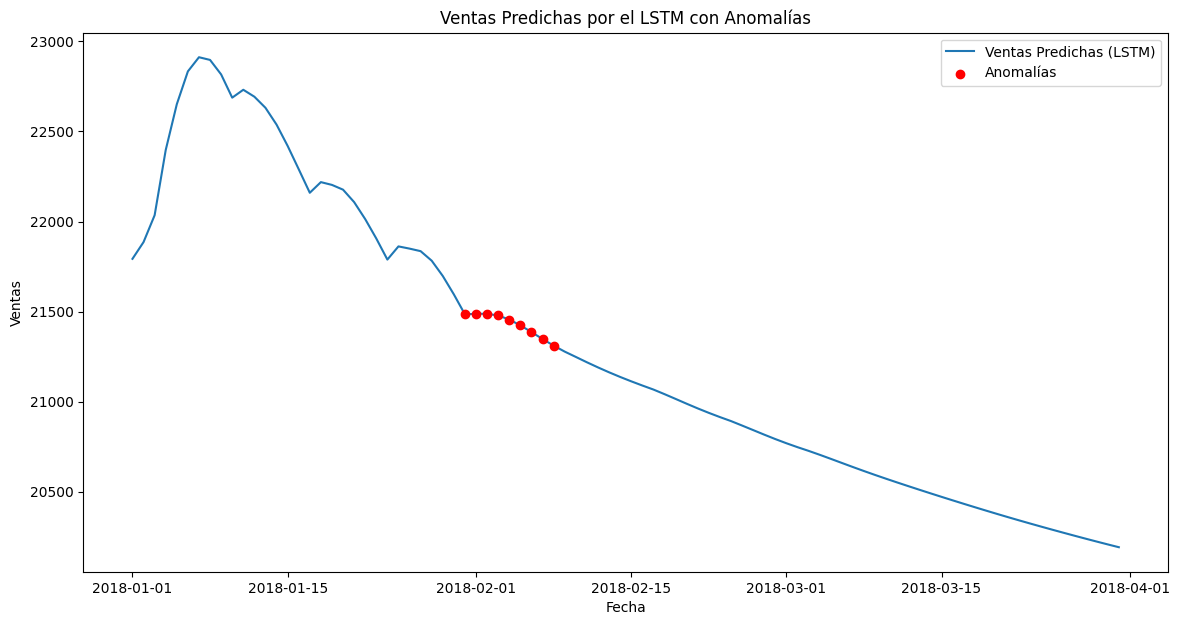

In [ ]:
# Plotear solo las predicciones del LSTM y las anomalías
plt.figure(figsize=(14, 7))
plt.plot(predictions_df['date'], predictions_df['predicted_sales'], label='Ventas Predichas (LSTM)')

# Marcar las anomalías en el gráfico
plt.scatter(final_anomalies_df['date'], final_anomalies_df['predicted_sales'], color='red', label='Anomalías', zorder=5)


plt.xlabel('Fecha')
plt.ylabel('Ventas')
plt.title('Ventas Predichas por el LSTM con Anomalías')
plt.legend()
plt.show()


In [ ]:
# Comparar las ventas predichas del día anómalo en 2018 con las ventas del mismo día en 2017
comparison_results = []

for anomaly_date in anomalous_sales['date']:
    year_2017_date = anomaly_date.replace(year=2017)
    year_2017_sales = daily_sales[daily_sales['date'] == year_2017_date]['sales'].values
    year_2018_sales = anomalous_sales[anomalous_sales['date'] == anomaly_date]['predicted_sales'].values
    if year_2017_sales.size > 0:
        comparison_results.append({
            'date': anomaly_date,
            '2017_sales': year_2017_sales[0],
            '2018_predicted_sales': year_2018_sales[0]
        })

comparison_df = pd.DataFrame(comparison_results)
print(comparison_df)

        date  2017_sales  2018_predicted_sales
0 2018-01-31       18486          21484.726562
1 2018-02-01       20612          21488.539062
2 2018-02-02       21875          21487.986328
3 2018-02-03       23501          21478.679688
4 2018-02-04       25018          21455.943359
5 2018-02-05       26084          21424.037109
6 2018-02-06       17584          21386.777344
7 2018-02-07       20433          21348.279297
8 2018-02-08       20292          21311.593750
